In [89]:
def generate_patches(image_dir: list, concentration: list, frame: list):
    """
    Generate image patches and their delta (difference) patches relative to a reference frame.

    Parameters:
    - image_dir (list): list of directories containing .tif image sequences
    - concentration (list): corresponding list of concentration values (used as keys)
    - frame (list): list of relative frame positions (e.g., [0.25, 0.5, 0.75, 1.0])

    Returns:
    - merged (dict): dictionary of image patches
    - merged_delta (dict): dictionary of delta image patches (difference from first frame)
    """

    # Map each concentration to its corresponding image directory
    images_dir = {
        mM: path for mM, path in zip(sorted(concentration), sorted(image_dir))
    }

    # For each concentration, get a sorted list of .tif images in its directory
    images_path = {
        mM: sorted([
            img for img in os.listdir(images_dir[mM]) if img.endswith('.tif')
        ])
        for mM in sorted(concentration)
    }

    # Store the first image for each concentration (used as a reference for delta computation)
    first_image = {
        mM: images_path[mM][0]
        for mM in sorted(concentration)
    }

    print(first_image)  # Optional: print reference images for debug

    # Select specific frames based on relative positions (e.g., 0.25 = 25% through the sequence)
    images_path = {
        mM: sorted([
            images_path[mM][min(int(idx * len(images_path[mM])), len(images_path[mM]) - 1)]
            for idx in sorted(frame)
        ])
        for mM in sorted(concentration)
    }

    # Load the selected grayscale images into memory for each concentration
    images = {
        mM: [
            cv.imread(os.path.join(images_dir[mM], img), cv.IMREAD_GRAYSCALE)
            for img in images_path[mM]
        ]
        for mM in sorted(concentration)
    }

    # Compute the absolute difference (delta) between each image and the first reference image
    delta = {
        mM: [
            cv.absdiff(img, cv.imread(os.path.join(images_dir[mM], first_image[mM]), cv.IMREAD_GRAYSCALE))
            for img in images[mM]
        ]
        for mM in sorted(concentration)
    }

    # Example: if frame = [0.2, 0.5, 0.75, 1.0], you'll get 4 frames per concentration
    # Each idx represents a fraction of the total frame count: 1.0 = last frame, 0.5 = middle, etc.

    patches = []
    patches_delta = []

    for mM in sorted(concentration):
        for img, img_delta, frm in zip(tqdm(images[mM]), delta[mM], frame):
            # Normalize image intensities to [0, 1]
            preprocessed_img = img.astype(np.float32) / 255.0
            preprocessed_img_delta = img_delta.astype(np.float32) / 255.0

            # Extract patches from both the raw image and its delta
            patches.append(extract_patches(preprocessed_img, concentration=mM, frame=frm))
            patches_delta.append(extract_patches(preprocessed_img_delta, concentration=mM, frame=frm))

    # Merge all patch dictionaries into two final dictionaries (raw and delta)
    merged = {}
    merged_delta = {}

    for dic, dic_delta in zip(patches, patches_delta):
        merged.update(dic)
        merged_delta.update(dic_delta)

    return merged, merged_delta

In [90]:
patches, patches_delta = generate_pacthes(['/home/ters-user/Documents/images_data/30mM_2/','/home/ters-user/Documents/images_data/50mM/'],['30mM(2)','50mM'],[0.25,0.5,0.75,0.95]) #List of dictionnaries : each dictionnary contains the patches of the considered frame

{'30mM(2)': '30mM_1.6V-w-snaps-18-27-56.446.tif', '50mM': '50mM_1.6V-w-snaps-18-55-11.257.tif'}


100%|██████████| 4/4 [00:57<00:00, 14.38s/it]


In [91]:
out = '/home/ters-user/Documents/particle_recognition_using_CNN/dataset/'

keys_delta, images_delta = list(patches_delta.keys()), list(patches_delta.values()) #
keys, images = list(patches.keys()), list(patches.values())

index = 0

count = 0

while True:
    filepath = os.path.join(out,f'{keys[index]}.png')
    img_delta = images_delta[index][0]
    img = images[index][0]

    if img_delta is None:
        print(f"Reading error : {keys[index]}")
        continue

    display = img_delta.copy()
    cv.putText(display, f"{count}" , (10, 30),
                cv.FONT_HERSHEY_SIMPLEX, 0.8, 255, 2)

    cv.imshow("display",display)
    key = cv.waitKey(0) & 0xFF

    if key == ord('q'):
        break
    elif key == 81 or key == ord('j'):  
        index = max(0, index - 1)
    elif key == 83 or key == ord('l'):  
        index = min(len(images) - 1, index + 1)
    elif key == ord('a'):
        cv.imwrite(filepath, img*255)
        cv.imwrite(f"{filepath.split('.p')[0]}_delta.png", img_delta*255)
        count += 1

cv.destroyAllWindows()

#Files with images (delta, original) choisies (les plus intéréssantes)

In [1]:
!pip install -q eikonalfm #Fast marching
!pip install -q ipympl # Interactive plotly


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [32]:
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter
import eikonalfm as fm
import cv2
import os
import zipfile
import os
from collections import defaultdict

In [41]:
def ind_to_coord(ind, n_rows, n_cols):
  """
  Gives the coordinated of an elements in a flattened matrix
  Example :
  -> [0,1,2,3,4,5,6,7,8,9,10,11] : flattened matrix
  ind_to_coord(6,3,4) -> 6 elements of 3 colums and 4 rows matrix
    -> [[0,1,2,3],
        [4,5,6,7],
        [8,9,10,11]]
        -> (1,2)
  """
  return np.unravel_index(ind,(n_rows, n_cols))

def coord_to_ind(coord, n_rows, n_cols):
  """
  Exact same as ind_to_coord but gives the element for a certain coordinate
  """
  return np.ravel_multi_index(coord, (n_rows, n_cols))

def neigh_coord_to_ind(coord,n_rows, n_cols):
  """
  returns coord_to_ind([x_top_neighbor, x_bottom_neighbor, x_left_neighbor, x_right_neighbor],
                       [y_top_neighbor, y_bottom_neighbor, y_left_neighbor, y_right_neighbor]

  Example :
  [0,1,2,
   3,4,5,
   6,7,8]
  # neigh_coord_to_ind((1,1),3,3) -> [1,7,3,5]
  """
  ix, iy = coord
  return coord_to_ind([[np.max([ix-1,0]), np.min([ix+1, n_rows-1]),ix,ix],
                       [iy, iy, np.max([iy-1,0]), np.min([iy+1, n_cols-1])]],
                      n_rows, n_cols)


def extract_curve(dist_map, end_point):
  """
  Extract curve from a distance map by rewinding from the final point to source point (distance=0)
  """
  n_rows, n_cols = dist_map.shape
  curve = [(end_point[0], end_point[1])] # intialize to the strating point
  u_min = dist_map[curve[-1]]
  while u_min != 0: # While the distance is not 0
    neigh_ind = neigh_coord_to_ind(curve[-1], n_rows, n_cols)
    u = dist_map[ind_to_coord(neigh_ind, n_rows, n_cols)] #Gives the whole distance
    arg_min = np.argmin(u)  # Gives index of the minimum distance
    u_min = np.min(u) # Give the value of this minimum distance
    curve.append(ind_to_coord(neigh_ind[arg_min], n_rows, n_cols))

  return np.array(np.flip(curve,0)) #initialy we have final point -> source
  # Now we flip it to have source -> final point

def slice_image(image, patch_size=224, stride=100):
    """
    Slices images of higher resolution into small slices of 224x224 which are fitted to our model which was trained with 224x224 images for imbalance considerations.
    
    🔧 Parameters:
    - image (np.array): considered image
    - patch_size (int, default : 224): considered slices size
    - stride (int, default=100) : corresponds to the number of pixels shifted (horizontaly and verticaly) between 2 images 

    🚀 Returns:
    - patches (list) : list of numpy array corresponding to each slice
        
    """
    h, w = image.shape[:2]
    patch_id = 0

    patches = []

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)

            patch_uint8 = (patch * 255).astype(np.uint8)
            patch_id += 1

    

    return patches


# Image processing 
Fast marching is based on the calculation of pixel intensity gradients. Some of our particles are very blurred and resemble the background. Additionally, our metallic surfaces are scratched due to polishing, which can cause the fast marching algorithm to mistake these scratches for particles, since their intensity is darker than the background. For this reason, it seems reasonable to subtract the initial frame of the video in order to remove these scratches and enhance the contrast between the particles and the background.

In [7]:
import requests
from tqdm import tqdm

url = "https://zenodo.org/records/14653184/files/30mM_1.6V-w-snaps.zip" 
local_filename = f"{url.split('/')[-1]}"

# Request in streaming mode
with requests.get(url, stream=True) as r:
    r.raise_for_status()  # error if incorrect url
    total_size = int(r.headers.get('content-length', 0))  # Total size
    block_size = 1024  # 1 Ko
    with open(local_filename, 'wb') as f, tqdm(
        desc=local_filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in r.iter_content(chunk_size=block_size):
            if chunk: 
                f.write(chunk)
                bar.update(len(chunk))

30mM_1.6V-w-snaps.zip: 100%|██████████| 4.23G/4.23G [09:28<00:00, 7.99MiB/s]


In [11]:
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall()

KeyboardInterrupt: 

In [27]:
image_dir = f"{local_filename.split(".zip")[0]}"
images_list = sorted([image_dir + "/" + img for img in os.listdir(image_dir)])
image = cv2.imread(images_list[400])
substracted_image = cv2.absdiff(image,cv2.imread(images_list[0]))

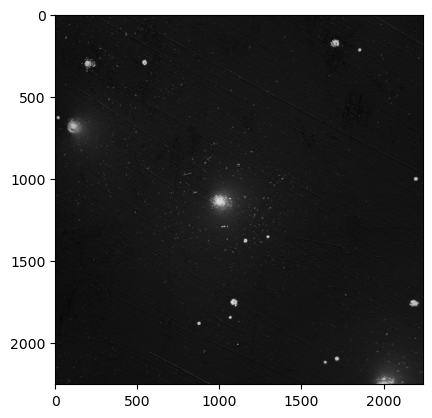

In [28]:
plt.imshow(substracted_image)

In [40]:
patches =  slice_image(substracted_image)

(2252, 2240)


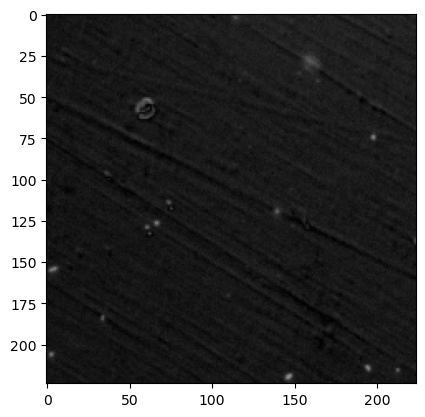

In [76]:
plt.imshow(patches[168])

# INTERACTIVE FIGURE
Click on the contours of the objects to put reference points that will be used by fast marching

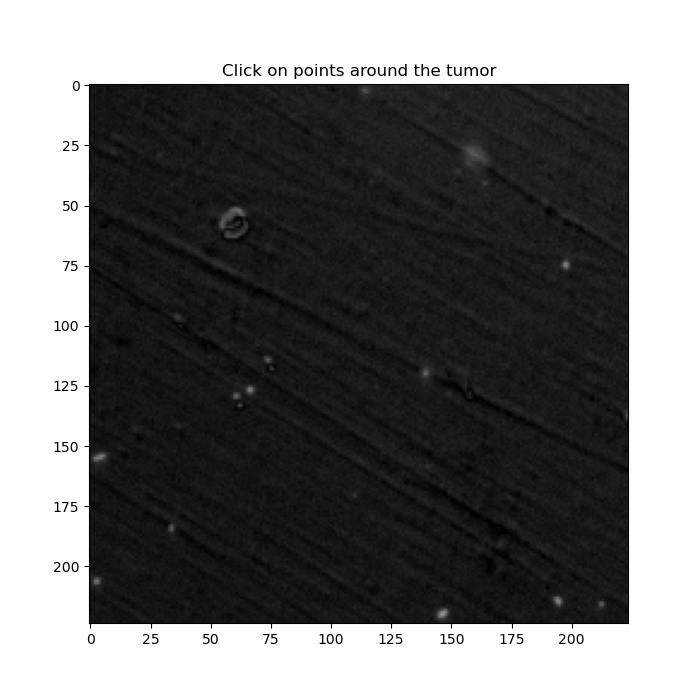

In [86]:
%matplotlib ipympl

fig = plt.figure(figsize=(7,7))
points = []

def onclick(event):
  if event.inaxes is not None : #If click is made inside the fig
    points.append([event.ydata, event.xdata])
    plt.scatter(int(event.xdata), int(event.ydata), marker = "+", c="y")

img = patches[168]

plt.imshow(img)
plt.title('Click on points around the tumor')

cid = fig.canvas.mpl_connect('button_press_event', onclick) #Connecting the event

# FAST MARCHING

In [87]:
points = np.round(points).astype('int')
img = patches[168]/255
img = img[:,:,0]
gauss = gaussian_filter(img,2) # Smoothing the image and reduce noise

gx = np.gradient(gauss, axis = 0) # Verticel gradient
gy = np.gradient(gauss, axis = 1) # Horizontal gradient

metric = 1/ (gx**2 + gy**2 + 1e-3) # adding epsilon = 1e-3 to provide division by 0

start = time.time()
curves = []

for i in range(len(points)-1): # compute curve for all the points exceptt the last one
  dist_map = fm.fast_marching(1/metric, points[i], (1,1), 2) # Gives a distance map depending on pixel gradients around the considered point
  curves.append(extract_curve(dist_map, points[i+1])) #Going from 2nd point to the the first point with minimal distance then 3rd point to 2nd point ... all the way to the last point while adding curve coordinates

dist_map = fm.fast_marching(1/metric, points[-1], (1,1), 2)
curves.append(extract_curve(dist_map, points[0])) # curve for the last point

print("Running time {:.2f}".format(time.time()-start))

Running time 0.04


# RESULTS

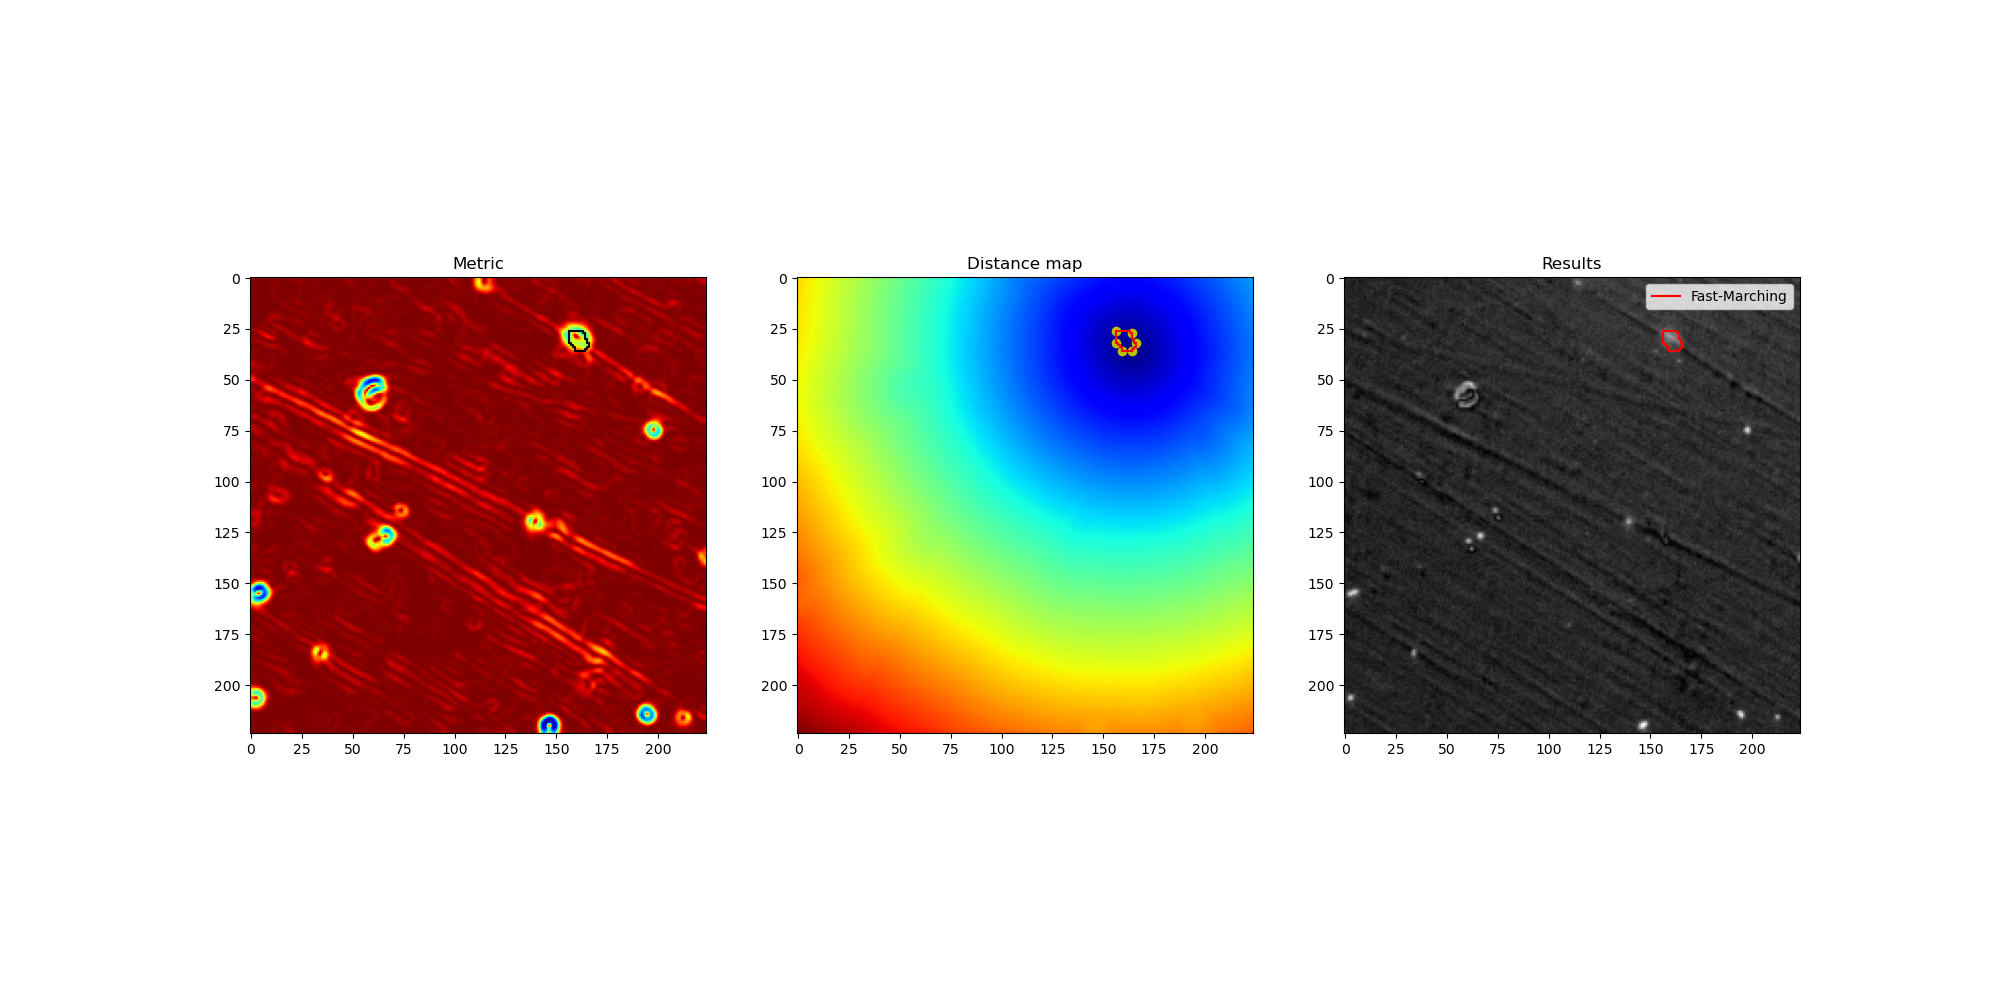

In [98]:
plt.figure(figsize=(20,10))

plt.subplot(131), plt.imshow(metric, 'jet'), plt.title('Metric')
for c in curves:
  plt.plot(c[:,1], c[:,0], c='black') # metrics showing area of high and low gradients

plt.subplot(132), plt.imshow(dist_map, 'jet'), plt.title('Distance map')
for c in curves:
  plt.plot(c[:,1], c[:,0], c='r')
plt.scatter(points[:,1], points[:,0], c= 'y') # Distance map

plt.subplot(133), plt.imshow(img, 'gray'), plt.title('Results')
for c in curves:
  plt.plot(c[:,1], c[:,0], c='r')
plt.plot(c[-1,1], c[-1,0], c='r', label = 'Fast-Marching') # Fast marching results : showing the computed 

plt.legend()
plt.savefig("../images/fast_marching_result")
plt.show()

